In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')



Mounted at /content/drive

Working directory: /content/drive/MyDrive/music_speech


In [ ]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
#import git


#if git.Repo('./').remotes.origin.url=='git@github.com:nilssommer1/music_speech.git':
    #print(f'\nRepository and working directory are fine.')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#import python code from seperate files
#from helpers.fourier_transform import load_wav, idft, dft_logmag, patches
#manually define helpers
import numpy as np
from scipy.signal import hann
from scipy.io import wavfile
	
def get_mag_phs(re_im):
    mag_phs=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        mag_phs.append([np.sqrt(re**2 + im**2), np.angle(re + im * 1j)])
    return np.array(mag_phs)


def get_logmag(re_im):
    logmag=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        logmag.append(np.log(np.sqrt(re**2 + im**2)))
    return np.array(logmag)


def get_re_im(mag_phs):
    re_im=[]
    for c in mag_phs:
        mag=c[0]
        phs=c[1]
        re_im.append([mag * np.cos(phs), mag * np.sin(phs)])
    return np.array(re_im)


def load_wav(filenames):
    wl=[]
    for name in filenames:
        _, w = wavfile.read(name)
        w = w.astype(np.float32)
        norm = np.max(np.abs(w))
        w = w / norm
        w -= np.mean(w)
        wl.append(w)
    return np.array(wl)


def dft(sounds, fft_chunks, fft_step=256, fft_size=512):
    #fft_chunks = len(sounds[0]) // fft_step
    hann_win = hann(fft_size)
    re_im = []
    for signal in sounds:
        s = []
        for i in range(fft_chunks):
            frame = signal[(i * fft_step):(i * fft_step + fft_size)]
            frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
            frame *= hann_win
            s.append(frame)
        s = np.array(s)
        N = s.shape[-1]
        k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
        x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
        freqs = np.dot(x, k)
        reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
        imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
        re_im.append([reals,imags])
    return np.array(re_im)


def dft_logmag(sounds, fft_chunks, fft_step=256, fft_size=512):
    re_im = dft(sounds, fft_chunks, fft_step, fft_size)
    return get_logmag(re_im)


def patches(sounds, patch_step, patch_size):
    num_sounds, num_samples, num_frequencies = sounds.shape
    num_patches = num_samples // patch_step
    if num_samples%patch_step>0: num_patches-=1
    p = np.zeros((num_sounds,num_patches,patch_size,num_frequencies))
    for i in range(num_sounds):
        for j in range(num_patches):
            p[i,j,:,:] = sounds[i,(j*patch_step):(j*patch_step+patch_size),:]
    return p


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal

In [ ]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


In [ ]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

train = speech + music
train_labels = np.zeros(len(train))
train_labels[0:len(speech)]=1 # speech = 1

print(train_labels.shape)

(104,)


In [ ]:
train_sounds = load_wav(train)
train_sounds.shape

(104, 661500)

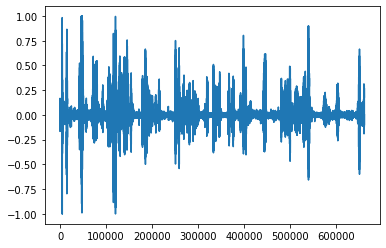

In [ ]:
plt.plot(train_sounds[0])
plt.show()

In [ ]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
print(train_logmag.shape)


(104, 2583, 256)


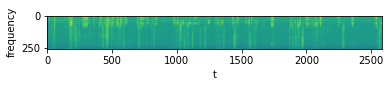

In [ ]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [ ]:
patch_step = 32
patch_size = 64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)

<MapDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>


In [ ]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(64, 256) : [-4.81290385 -4.04347775] : [-2.87845116 -4.59657998]
(64, 256) : [-4.04347775 -4.11778569] : [-4.59657998 -5.92376022]
(64, 256) : [-4.11778569 -8.16937535] : [-5.92376022 -4.18735623]
(64, 256) : [-8.16937535 -7.79998655] : [-4.18735623 -3.2838033 ]
(64, 256) : [-7.79998655 -2.8724503 ] : [-3.2838033  -4.72239614]
(64, 256) : [-2.8724503  -4.56824246] : [-4.72239614 -4.41037684]
(64, 256) : [-4.56824246 -5.03616789] : [-4.41037684 -6.67385783]
(64, 256) : [-5.03616789 -4.15384821] : [-6.67385783 -4.83656759]
(64, 256) : [-4.15384821 -6.82477327] : [-4.83656759 -3.72271512]
(64, 256) : [-6.82477327 -3.63555826] : [-3.72271512 -4.47068765]


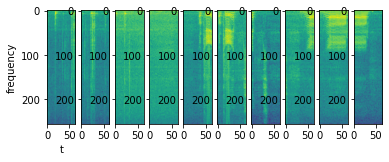

In [ ]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [ ]:
#train_logmag_patches = patches(train_logmag,patch_step,patch_size)
#print(train_logmag_patches.shape)

(104, 79, 64, 256)


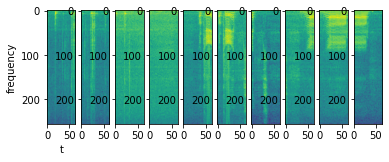

In [ ]:
#for i in range(n):
    #plt.subplot(1,n,i+1)
    #plt.imshow(train_logmag_patches[0,i].T)
    #if i == 0:
    #    plt.xlabel('t')
    #    plt.ylabel('frequency')
#plt.show()

<MapDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>


batches erstellen aus den Time-Samples




Code From RNN Tutorial

Model:

In [ ]:
# Parameters
n_input = 7  # word sequence to predict the following word

# number of units in RNN cells
n_hidden = [256, 512, 1024, 512, 128]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=n_input)) #128 dimensions

for layer_i, n_h in enumerate(n_hidden):
  model.add(tf.keras.layers.LSTM(n_h, return_sequences=True, name=f'{layer_i}_lstm{n_h}'))

model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

model.compile(optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0 = model.get_weights()  # to reset model to original state:
model.summary()

In [ ]:
# create tf.data.Dataset object
word_dataset = tf.data.Dataset.from_tensor_slices(words_as_int)

In [ ]:
# take metod generates elements:
for i in word_dataset.take(8):
  print(reverse_dictionary[i.numpy()])

In [ ]:
sequences = word_dataset.batch(n_input+1, drop_remainder=True) 

In [ ]:
# helper for int-to-text conversion
to_text = lambda arr:' '.join([reverse_dictionary[it] for it in arr])

In [ ]:
for item in sequences.take(5):
  print(to_text(item.numpy()))

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]

    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', to_text(input_example.numpy()))
  print ('Target data:', to_text(target_example.numpy()))

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
dataset

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
print('input: ', to_text(input_example_batch.numpy()[0]))
print('output:', to_text(target_example_batch.numpy()[0]))
print('pred:  ', to_text(example_batch_predictions.numpy()[0].argmax(axis=1)))

Train:

In [ ]:
#model.set_weights(W0)
history = model.fit(dataset, epochs=400, verbose=1)

In [ ]:
def draw_history(hist):
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].plot(hist.epoch, hist.history['loss'])
  if 'val_loss' in hist.history:
    axs[0].plot(hist.epoch, hist.history['val_loss'])
  axs[0].legend(('training loss', 'validation loss'))
  axs[1].plot(hist.epoch, hist.history['accuracy'])
  if 'val_accuracy' in hist.history:
    axs[1].plot(hist.epoch, hist.history['val_accuracy'])

  axs[1].legend(('training accuracy', 'validation accuracy'))
  plt.show()

In [ ]:
draw_history(history)